# Part I: Replicating Models from Class

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from math import e
from scipy.optimize import minimize
from scipy.stats import poisson
from scipy.special import gamma
from scipy.special import gammaln
from scipy.special import factorial

### Question 1: Consider the hard candy example from class. The associated data is in the file candy.csv. Develop the following models discussed in class using maximum likelihood estimation (MLE):
### a. the Poisson model,
### b. the NBD model,
### c. the Zero-Inflated NBD model, and
### d. Finite Mixture models for 2, 3, and 4 segments.
### Report your code and all relevant details, including the estimated values of the parameters for each model and the corresponding log-likelihood values. 
### --------------------------------------------------------------------------------------------------------------------------------

### (a) The Poisson Model

In [2]:
# Reading the dataset
candy = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/candy.csv')
candy

,Packs,People
0,0,102
1,1,54
2,2,49
3,3,62
4,4,44
5,5,25
6,6,26
7,7,15
8,8,15
9,9,10


In [3]:
# Defining the log-likelihood function
def LL_p(params, packs, people):
    l = params
    prob = []
    ll = []
    
    for i in range(len(packs)):
        if i == 0:
            prob.append(math.exp(-l))
        else:
            prob.append(((l**i)*(math.exp(-l)))/math.factorial(i))
        ll.append(people[i] * math.log(prob[i]))
    return ll

In [4]:
# Defining the negative log-likelihood function
def NLL_p(params, packs, people):
    return(-np.sum(LL_p(params, packs, people)))

In [5]:
# Setting up the parameters
params = np.array((0.5))
packs = np.array(candy.Packs)
people = np.array(candy.People)

In [6]:
np.sum(people)

456

In [7]:
# Minimizing the negative log likelihood function
soln_p = minimize(
    NLL_p,
    args = (packs, people),
    x0 = params,
    bounds = [(0.000001, None)],
    tol = 1e-10,
    options = {'ftol' : 1e-8}
)

In [8]:
# Printing the solution
soln_p

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1544.996390448971
        x: [ 3.991e+00]
      nit: 9
      jac: [-2.274e-05]
     nfev: 20
     njev: 10
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [9]:
# Looking at the optimal value of lambda (l)
l1 = soln_p.x[0]
l1

3.991227805463944

In [10]:
# Maximum value of log-likelihood 
ll_poi = -soln_p.fun
ll_poi

-1544.996390448971

In [11]:
# Predicting the number of people given exposure for the week data we have.
def predict_p(op_l, packs, t_people):
    predP = []
    for i in range(len(packs)):
        pred = ((math.exp(-op_l) * (op_l ** i)) / math.factorial(i)) * t_people
        predP.append(pred)
    return predP

In [12]:
# Printing the predicted values
preds = predict_p(l1, packs, np.sum(people))

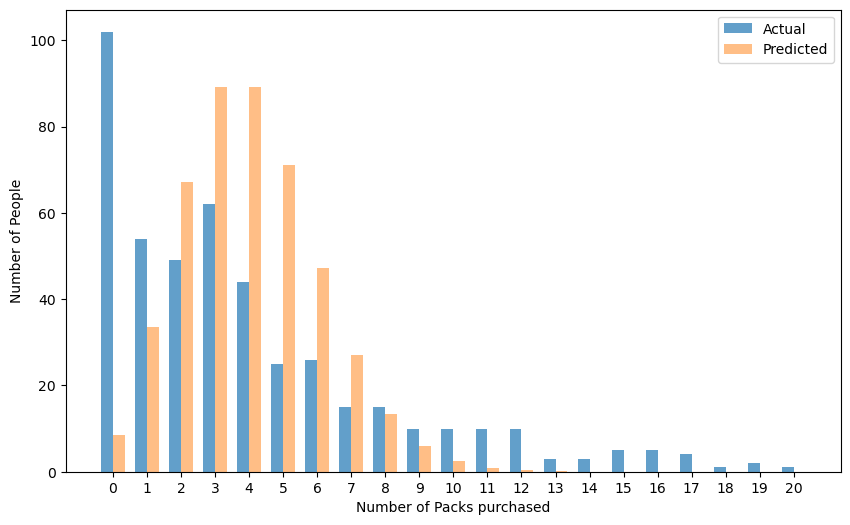

In [13]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = range(len(packs))

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], preds, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Packs purchased")
plt.ylabel("Number of People")
plt.xticks(x, packs)
plt.legend()
plt.show()

### (b) The NBD Model 

In [14]:
# Defining the recursive function for k > 0
def nbd(k, n, a, pmf_k_minus_1):
    return (n + k - 1) / (k * (a + 1)) * pmf_k_minus_1

In [15]:
# Defining the log-likelihood function
def LL_nbd(params, packs, people):
    n, a = params
    pmf = np.zeros(len(packs))
    pmf[0] = (a / (a + 1)) ** n
    ll_nbd = people[0] * np.log(pmf[0])
    
    for k in range(1, len(packs)):
        pmf[k] = nbd(k, n, a, pmf[k - 1])
        ll_nbd += people[k] * np.log(pmf[k])
    
    return -ll_nbd

In [16]:
# Passing the parameters
params = np.array([1.0, 0.5])
packs = np.array(candy.Packs)
people = np.array(candy.People)

In [17]:
# Minimizing the negative log-likelihood value as returend by the LL() function.
soln_nbd = minimize(
    LL_nbd,
    args=(packs, people),
    x0=params,
    bounds=[(0.000001, None), (0.000001, None)],  # 'r' and 'a' should be >= 0
    tol=1e-10,
    options={'ftol': 1e-8}
)

In [18]:
# Printing the optimal n and a values
optimal_n, optimal_a = soln_nbd.x
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")

Optimal n: 0.9976273946476482
Optimal a: 0.24995518278729173


In [19]:
# Maximum value of log-likelihood 
ll_nbd = -soln_nbd.fun
ll_nbd

-1140.0237462446792

In [20]:
# Predicting number of people against number of exposures using the NBD Model.
def predict_nbd(params, packs, total_people):
    n, a = params
    predictions = np.zeros(len(packs))
    predictions[0] = (a / (a + 1)) ** n
    
    for k in range(1, len(packs)):
        predictions[k] = nbd(k, n, a, predictions[k - 1])
    
    # Scale the predictions to the total number of people
    scaled_predictions = predictions * total_people
    
    return scaled_predictions

# Total numbe of people in the dataset
total_people = np.sum(people)

# Use the fitted parameters to make predictions and scale them to total people
optimal_params = (optimal_n, optimal_a)
predicted_people = predict_nbd(optimal_params, packs, total_people)

In [21]:
# Looking into the predicted people.
predicted_people

array([91.53581971, 73.05753245, 58.37878438, 46.66776477, 37.31340481,
       29.83762884, 23.86151954, 19.08342968, 15.26276323, 12.20742937,
        9.7639765 ,  7.80977641,  6.24680979,  4.99671491,  3.99683779,
        3.1970791 ,  2.5573757 ,  2.04568837,  1.63639365,  1.30899838,
        1.04711202])

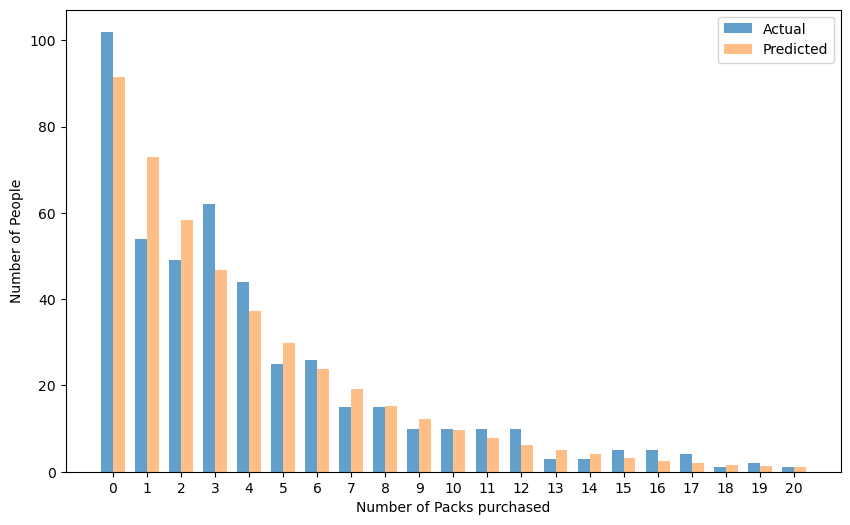

In [22]:
# Plotting the actual and predicted histograms.

bar_width = 0.35
x = range(len(packs))

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Packs purchased")
plt.ylabel("Number of People")
plt.xticks(x, packs)
plt.legend()
plt.show()

### (c) The Zero Inflated NBD Model 

In [23]:
# Defining the log-likelihood function
def zi_nbd(params, packs, people):
    pi, n, alpha = params

    ll_zi_nbd = 0
    for i in range(len(packs)):
        if i==0:
            ll_zi_nbd += people[i]*(np.log(pi+(1-pi)*((alpha/(alpha+1))**n)))
        else:
            ll_zi_nbd += people[i] * (np.log(1 - pi) + np.log(gamma(n+int(packs[i]))) - np.log(gamma(n)) - np.log(factorial(int(packs[i]))) + n * np.log(alpha) - (n+int(packs[i])) * np.log(alpha + 1))
    return -(ll_zi_nbd)

In [24]:
# Giving initial values for the parameters.
params = [0.5, 1, 1]

In [25]:
# Minimizing the negative Log-Likelihood Function
zi_nbd_res = minimize(zi_nbd, params, args=(packs, people), method='L-BFGS-B',bounds=[(0.000001,0.99999999),(0.00000001,None),(0.00000001,None)])

optimal_pi, optimal_n, optimal_alpha = zi_nbd_res.x

In [26]:
# Printing out the optimal values
print(f"Optimal pi: {optimal_pi}")
print(f"Optimal n: {optimal_n}")
print(f"Optimal alpha: {optimal_alpha}")

Optimal pi: 0.11310334393364121
Optimal n: 1.5039128179434913
Optimal alpha: 0.33418637623221303


In [27]:
# Maximum value of log-likelihood 
ll_zinbd = -zi_nbd_res.fun
ll_zinbd

-1136.1656408323975

### (d) Finite Mixture models for 2, 3, and 4 segments

### 2 - Segment Model: 

In [28]:
# Defining the log-likelihood function
def two_seg(params,packs, people):
    pi,l1,l2 = params
    ll = np.sum(people*np.log((pi*poisson.pmf(packs, l1))+((1-pi)*poisson.pmf(packs, l2))))
    return ll*(-1)

In [29]:
# Minimizing the negative-log-likelihood function and looking into the solution
soln_2seg = minimize(two_seg, args=(packs, people),x0=np.array((0.8,1,1)), method='L-BFGS-B',bounds=[(0.000001,0.99999999),(0.00000001,None),(0.00000001,None)])

print(soln_2seg)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1188.8328271731098
        x: [ 2.991e-01  9.121e+00  1.802e+00]
      nit: 16
      jac: [ 8.868e-04  1.364e-04 -9.095e-05]
     nfev: 72
     njev: 18
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [30]:
# Getting the optimal parameters
optimal_pi, optimal_l1, optimal_l2 = soln_2seg.x

In [31]:
# Printing out the optimal values
print(f"Optimal pi_1: {optimal_pi}")
print(f"Optimal pi_2: {1-optimal_pi}")
print(f"Optimal l1: {optimal_l1}")
print(f"Optimal l2: {optimal_l2}")

Optimal pi_1: 0.2991141014958068
Optimal pi_2: 0.7008858985041932
Optimal l1: 9.120695741570547
Optimal l2: 1.8021539150737973


In [32]:
# Maximum value of log-likelihood 
ll_2seg = -soln_2seg.fun
ll_2seg

-1188.8328271731098

### 3 - Segment Model 

In [33]:
# Defining the log-likelihood function
def three_segment(params,packs, people):
    l1,l2,l3,theta1,theta2 = params
    pi1=np.exp(theta1)/(np.exp(theta1)+np.exp(theta2)+np.exp(0))
    pi2=np.exp(theta2)/(np.exp(theta1)+np.exp(theta2)+np.exp(0))
    ll = np.sum(people*np.log((pi1*poisson.pmf(packs, l1))+((1-pi1-pi2)*poisson.pmf(packs, l3))+(pi2*poisson.pmf(packs, l2))))
    #print(ll)
    #print(params)
    return ll*(-1)

In [34]:
# Minimizing the negative-log-likelihood function and looking into the solution
soln_3seg = minimize(three_segment,args=(packs, people),x0=np.array((6,3,12,1,-1)), method='L-BFGS-B',bounds=[(0.00000001,None),(0.00000001,None),(0.00000001,None),(None,None),(None,None)])

print(soln_3seg)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1132.0429842568255
        x: [ 3.483e+00  2.905e-01  1.122e+01  1.105e+00  4.304e-01]
      nit: 18
      jac: [-1.137e-04  1.819e-04  4.547e-05  0.000e+00  9.095e-05]
     nfev: 132
     njev: 22
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [35]:
# Getting the optimal parameters
optimal_l1, optimal_l2, optimal_l3, optimal_theta1, optimal_theta2 = soln_3seg.x

In [36]:
# Calculating the probability of s=respective segments
pi1=np.exp(optimal_theta1)/(np.exp(optimal_theta1)+np.exp(optimal_theta2)+np.exp(0))
pi2=np.exp(optimal_theta2)/(np.exp(optimal_theta1)+np.exp(optimal_theta2)+np.exp(0))
pi3=1-pi1-pi2

In [37]:
# Printing out the optimal values
print(f"Optimal l1: {optimal_l1}")
print(f"Optimal l2: {optimal_l2}")
print(f"Optimal l3: {optimal_l3}")
print(f"Optimal pi1: {pi1}")
print(f"Optimal pi2: {pi2}")
print(f"Optimal pi3: {pi3}")

Optimal l1: 3.4833227082824654
Optimal l2: 0.2905454446189003
Optimal l3: 11.215823596483384
Optimal pi1: 0.5432689381632283
Optimal pi2: 0.2767683150419202
Optimal pi3: 0.17996274679485152


In [38]:
# Maximum value of log-likelihood 
ll_3seg = -soln_3seg.fun
ll_3seg

-1132.0429842568255

### 4 - Segment Model 

In [39]:
# Defining the log-likelihood function
def four_segment(params,packs, people):
    l1,l2,l3,l4,theta1,theta2,theta3 = params
    pi1=np.exp(theta1)/(np.exp(theta1)+np.exp(theta2)+np.exp(theta3)+np.exp(0))
    pi2=np.exp(theta2)/(np.exp(theta1)+np.exp(theta2)+np.exp(theta3)+np.exp(0))
    pi3=np.exp(theta3)/(np.exp(theta1)+np.exp(theta2)+np.exp(theta3)+np.exp(0))
    ll = np.sum(people*np.log((pi1*poisson.pmf(packs, l1))+(pi2*poisson.pmf(packs, l2))+(pi3*poisson.pmf(packs, l3))+((1-pi1-pi2-pi3)*poisson.pmf(packs, l4))))
    return ll*(-1)

In [40]:
# Minimizing the negative-log-likelihood function and looking into the solution
soln_4seg = minimize(four_segment,args=(packs, people),x0=np.array((0.6,0.3,1,1,1,-1,1)), method='L-BFGS-B',bounds=[(0.00000001,None),(0.00000001,None),(0.00000001,None),(0.00000001,None),(None,None),(None,None),(None,None)])

print(soln_4seg)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1130.0705910547115
        x: [ 7.418e+00  2.047e-01  1.287e+01  3.002e+00 -1.200e+00
            -7.220e-01 -1.598e+00]
      nit: 47
      jac: [-1.137e-04 -4.093e-04  9.095e-05 -1.364e-04 -2.956e-04
             7.049e-04 -1.592e-04]
     nfev: 448
     njev: 56
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>


In [41]:
# Getting the optimal parameters
optimal_l1, optimal_l2, optimal_l3, optimal_l4, optimal_theta1, optimal_theta2, optimal_theta3= soln_4seg.x

In [42]:
# Calculating the probability values for segments overall.
pi1=np.exp(optimal_theta1)/(np.exp(optimal_theta1)+np.exp(optimal_theta2)+np.exp(optimal_theta3)+np.exp(0))
pi2=np.exp(optimal_theta2)/(np.exp(optimal_theta1)+np.exp(optimal_theta2)+np.exp(optimal_theta3)+np.exp(0))
pi3=np.exp(optimal_theta3)/(np.exp(optimal_theta1)+np.exp(optimal_theta2)+np.exp(optimal_theta3)+np.exp(0))
pi4=1-pi1-pi2-pi3

In [43]:
# Printing out the optimal values
print(f"Optimal l1: {optimal_l1}")
print(f"Optimal l2: {optimal_l2}")
print(f"Optimal l3: {optimal_l3}")
print(f"Optimal l4: {optimal_l4}")
print(f"Optimal pi1: {pi1}")
print(f"Optimal pi2: {pi2}")
print(f"Optimal pi3: {pi3}")
print(f"Optimal pi4: {pi4}")

Optimal l1: 7.418103964600629
Optimal l2: 0.2047339795591281
Optimal l3: 12.87256421952046
Optimal l4: 3.001939650239763
Optimal pi1: 0.15139059334888985
Optimal pi2: 0.2441989403000645
Optimal pi3: 0.10169418006412524
Optimal pi4: 0.5027162862869204


In [44]:
# Maximum value of log-likelihood 
ll_4seg = -soln_4seg.fun
ll_4seg

-1130.0705910547115

### Question 2: Evaluate the models developed; explain which of them is best, and why. Are there any significant differences among the results from these models? If so, what exactly are these differences? Discuss what you believe could be causing the differences. 

In [45]:
# Poisson Model
k = 1
n = 456
aic_p = (2*k) - 2*(-1544.996)
bic_p = k*np.log(n) - 2*(-1544.996)
print("Poisson Model AIC: ", aic_p)
print("Poisson Model BIC: ", bic_p)

Poisson Model AIC:  3091.992
Poisson Model BIC:  3096.1144928095146


In [46]:
# NBD Model
k = 2
n = 456
aic_n = (2*k) - 2*(-1140.024)
bic_n = k*np.log(n) - 2*(-1140.024)
print("NBD Model AIC: ", aic_n)
print("NBD Model BIC: ", bic_n)

NBD Model AIC:  2284.048
NBD Model BIC:  2292.2929856190285


In [47]:
# Zero Inflated NBD Model
k = 3
n = 456
aic_zn = (2*k) - 2*(-1136.166)
bic_zn = k*np.log(n) - 2*(-1136.166)
print("Zero Inflated NBD Model AIC: ", aic_zn)
print("Zero Inflated NBD Model BIC: ", bic_zn)

Zero Inflated NBD Model AIC:  2278.332
Zero Inflated NBD Model BIC:  2290.699478428543


In [48]:
# 2-segment Model
k = 3
n = 456
aic_2seg = (2*k) - 2*(-1188.833)
bic_2seg = k*np.log(n) - 2*(-1188.833)
print("2 segment Model AIC: ", aic_2seg)
print("2 segment Model BIC: ", bic_2seg)

2 segment Model AIC:  2383.666
2 segment Model BIC:  2396.0334784285433


In [49]:
# 3-segment Model
k = 5
n = 456
aic_3seg = (2*k) - 2*(-1132.043)
bic_3seg = k*np.log(n) - 2*(-1132.043)
print("3 segment Model AIC: ", aic_3seg)
print("3 segment Model BIC: ", bic_3seg)


3 segment Model AIC:  2274.086
3 segment Model BIC:  2294.6984640475716


In [50]:
# 4-segment Model
k = 7
n = 456
aic_4seg = (2*k) - 2*(-1130.071)
bic_4seg = k*np.log(n) - 2*(-1130.071)
print("4 segment Model AIC: ", aic_4seg)
print("4 segment Model BIC: ", bic_4seg)

4 segment Model AIC:  2274.142
4 segment Model BIC:  2302.9994496666004


In [51]:
# Likelihood Ratio Test:
# Between NBD Model and Zero-Inflated NBD Model.
# Between 2 segment and 3 segment Model
# Between 2 segment and 4 segment Model
# Between 3 segment and 4 segment Model

In [52]:
# NBD Model vs Zero Inflated NBD Model
# NBD Model LL = 1140.0237462446792
# Zero Inflated NBD Model LL = 1136.1656408323975
lrt_nbd_zinbd = 2 * (1136.1656408323975 - 1140.0237462446792)
lrt_nbd_zinbd

-7.7162108245634045

In [53]:
# 2 segment vs 3 segment Models
# 2 segment model LL = 1188.8328271731098
# 3 segment Model LL = 1132.0429842568255
lrt_2_3 = 2 * (1132.0429842568255 - 1188.8328271731098)
lrt_2_3

-113.57968583256843

In [54]:
# 2 segment vs 4 segment models
# 2 segment model LL = 1188.8328271731098
# 4 segment model LL = 1130.0705910547115
lrt_2_4 = 2 * (1130.0705910547115- 1188.8328271731098)
lrt_2_4

-117.52447223679656

In [55]:
# 3 segment vs 4 segment Models
# 3 segment model LL = 1132.0429842568255
# 4 segment Model LL = 1130.0705910547115
lrt_3_4 = 2 * (1130.0705910547115-1132.0429842568255)
lrt_3_4

-3.9447864042281253

### Question 3: Based on the 2, 3, and 4-segment finite mixture models, how many packs are the following customers likely to purchase over the next 8 weeks?
### a. a customer who purchased 5 packs in the past week, and
### b. a customer who purchased 9 packs in the past week. 

In [56]:
# Using 2 segment model: 5 packs
pi_1 = 0.2991141014958068
pi_2 = 0.7008858985041932
l1 = 9.120695741570547
l2 = 1.8021539150737973

pr1 = (pi_1 * ((l1**5) * math.exp(-l1)))/math.factorial(5)
pr2 = (pi_2 * ((l2**5) * math.exp(-l2)))/math.factorial(5)

prob1 = pr1/(pr1+pr2)
prob2 = pr2/(pr1+pr2)

# For 8 weeks:
prob_8 = (prob1*l1 + prob2*l2)* 8
print("Number of purchases over next 8 weeks is: ", prob_8)

Number of purchases over next 8 weeks is:  42.78061878491957


In [57]:
# Using 2 segment model: 9 packs
pi_1 = 0.2991141014958068
pi_2 = 0.7008858985041932
l1 = 9.120695741570547
l2 = 1.8021539150737973

pr1 = (pi_1 * ((l1**9) * math.exp(-l1)))/math.factorial(9)
pr2 = (pi_2 * ((l2**9) * math.exp(-l2)))/math.factorial(9)

prob1 = pr1/(pr1+pr2)
prob2 = pr2/(pr1+pr2)

# For 8 weeks:
prob_8 = (prob1*l1 + prob2*l2)* 8
print("Number of purchases over next 8 weeks is: ", prob_8)

Number of purchases over next 8 weeks is:  72.87074622782943


In [58]:
# Using 3 segment model: 5 packs
l1 = 3.4833227082824654
l2 = 0.2905454446189003
l3 = 11.215823596483384
pi_1 = 0.5432689381632283
pi_2 = 0.2767683150419202
pi_3 = 0.17996274679485152

pr1 = (pi_1 * ((l1**5) * math.exp(-l1)))/math.factorial(5)
pr2 = (pi_2 * ((l2**5) * math.exp(-l2)))/math.factorial(5)
pr3 = (pi_3 * ((l3**5) * math.exp(-l3)))/math.factorial(5)

prob1 = pr1/(pr1+pr2+pr3)
prob2 = pr2/(pr1+pr2+pr3)
prob3 = pr3/(pr1+pr2+pr3)

# For 8 weeks:
prob_8 = (prob1*l1 + prob2*l2 + prob3*l3)* 8
print("Number of purchases over next 8 weeks is: ", prob_8)

Number of purchases over next 8 weeks is:  30.825197547445697


In [59]:
# Using 3 segment model: 9 packs
l1 = 3.4833227082824654
l2 = 0.2905454446189003
l3 = 11.215823596483384
pi_1 = 0.5432689381632283
pi_2 = 0.2767683150419202
pi_3 = 0.17996274679485152

pr1 = (pi_1 * ((l1**9) * math.exp(-l1)))/math.factorial(9)
pr2 = (pi_2 * ((l2**9) * math.exp(-l2)))/math.factorial(9)
pr3 = (pi_3 * ((l3**9) * math.exp(-l3)))/math.factorial(9)

prob1 = pr1/(pr1+pr2+pr3)
prob2 = pr2/(pr1+pr2+pr3)
prob3 = pr3/(pr1+pr2+pr3)

# For 8 weeks:
prob_8 = (prob1*l1 + prob2*l2 + prob3*l3)* 8
print("Number of purchases over next 8 weeks is: ", prob_8)

Number of purchases over next 8 weeks is:  80.06337810204865


In [60]:
# Using 4 segment model: 5 packs
l1 = 7.418103964600629
l2 = 0.2047339795591281
l3 = 12.87256421952046
l4 = 3.001939650239763
pi_1 = 0.15139059334888985
pi_2 = 0.2441989403000645
pi_3 = 0.10169418006412524
pi_4 = 0.5027162862869204

pr1 = (pi_1 * ((l1**5) * math.exp(-l1)))/math.factorial(5)
pr2 = (pi_2 * ((l2**5) * math.exp(-l2)))/math.factorial(5)
pr3 = (pi_3 * ((l3**5) * math.exp(-l3)))/math.factorial(5)
pr4 = (pi_4 * ((l4**5) * math.exp(-l4)))/math.factorial(5)

prob1 = pr1/(pr1+pr2+pr3+pr4)
prob2 = pr2/(pr1+pr2+pr3+pr4)
prob3 = pr3/(pr1+pr2+pr3+pr4)
prob4 = pr4/(pr1+pr2+pr3+pr4)

# For 8 weeks:
prob_8 = (prob1*l1 + prob2*l2 + prob3*l3 + prob4*l4)* 8
print("Number of purchases over next 8 weeks is: ", prob_8)

Number of purchases over next 8 weeks is:  33.67140784290211


In [61]:
# Using 4 segment model: 9 packs
l1 = 7.418103964600629
l2 = 0.2047339795591281
l3 = 12.87256421952046
l4 = 3.001939650239763
pi_1 = 0.15139059334888985
pi_2 = 0.2441989403000645
pi_3 = 0.10169418006412524
pi_4 = 0.5027162862869204

pr1 = (pi_1 * ((l1**9) * math.exp(-l1)))/math.factorial(9)
pr2 = (pi_2 * ((l2**9) * math.exp(-l2)))/math.factorial(9)
pr3 = (pi_3 * ((l3**9) * math.exp(-l3)))/math.factorial(9)
pr4 = (pi_4 * ((l4**9) * math.exp(-l4)))/math.factorial(9)

prob1 = pr1/(pr1+pr2+pr3+pr4)
prob2 = pr2/(pr1+pr2+pr3+pr4)
prob3 = pr3/(pr1+pr2+pr3+pr4)
prob4 = pr4/(pr1+pr2+pr3+pr4)

# For 8 weeks:
prob_8 = (prob1*l1 + prob2*l2 + prob3*l3 + prob4*l4)* 8
print("Number of purchases over next 8 weeks is: ", prob_8)

Number of purchases over next 8 weeks is:  69.45323035265085


# Part II: Analysis of New Data

In [62]:
# Reading the dataset
articls = pd.read_csv('/Users/ramyavissapragada/Desktop/buan6383/articles.csv')
articls

,articles,female,married,kids,prestige,menpubs
0,0,0,1,0,2.52,7
1,0,1,0,0,2.05,6
2,0,1,0,0,3.75,6
3,0,0,1,1,1.18,3
4,0,1,0,0,3.75,26
...,...,...,...,...,...,...
910,11,0,1,2,2.86,7
911,12,0,1,1,4.29,35
912,12,0,1,1,1.86,5
913,16,0,1,0,1.74,21


### Question 1: Estimate all relevant parameters for Poisson regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. What are the managerial takeaways – which customer characteristics seem to be important? Predict the number of people purchasing 0, …, 20, 20+ packs based on the Poisson regression. Explain how the predicted values are obtained using the case of 5 packs (show your calculations). Graph the original and predicted number of packs. 

In [63]:
# Defining the log-likelihood function
def LL_pr(params, v, x1, x2, x3, x4, x5):
    l0, b1, b2, b3, b4, b5 = params
    li = []
    for i in range(len(v)):
        li.append(l0*np.exp(b1*x1[i] + b2*x2[i] + b3*x3[i] + b4*x4[i] + b5*x5[i]))
       
    #prob_pr = []
    ll = []
    
    for i in range(len(v)):
            ll_1 = v[i]*np.log(li[i])
            ll_2 = (li[i])
            ll_3a = np.math.factorial(v[i])
            ll_3 = np.log(float(ll_3a))
            ll.append(ll_1-ll_2-ll_3)

    return ll


In [64]:
# Defining the negative log-likelihood function
def NLL_pr(params, v, x1, x2, x3, x4, x5):
    return(-np.sum(LL_pr(params, v, x1, x2, x3, x4, x5)))

In [65]:
# Setting up the parameters
params = np.array([0.5, 0.1, 0.2, 0.5, -0.3, -0.4])
v = np.array(articls.articles)
x1 = np.array(articls.female)
x2 = np.array(articls.married)
x3 = np.array(articls.kids)
x4 = np.array(articls.prestige)
x5 = np.array(articls.menpubs)

In [66]:
# Minimizing the Negative Log-Likelihood of the model established.
soln_pr = minimize(
    NLL_pr, 
    args=(v, x1, x2, x3, x4, x5),
    x0=np.array((1,0.2,0.3,0.1,-0.3, -0.4)),
    bounds=[(0.00000001,None),(None,None),(None,None),(None,None),(None,None), (None,None)],
    tol=1e-10,
    options={'ftol':1e-8}
)

In [67]:
# Looking into the solution. 
soln_pr

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1651.0563161691005
        x: [ 1.356e+00 -2.246e-01  1.552e-01 -1.849e-01  1.282e-02
             2.554e-02]
      nit: 52
      jac: [ 2.501e-04 -5.684e-04  1.137e-04  1.614e-03  7.503e-04
             1.171e-02]
     nfev: 448
     njev: 64
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [68]:
# Printing the optimal parameters
optimal_l0, optimal_b1, optimal_b2, optimal_b3, optimal_b4, optimal_b5 = soln_pr.x
print(f"Optimal l0: {optimal_l0}")
print(f"Optimal b1: {optimal_b1}")
print(f"Optimal b2: {optimal_b2}")
print(f"Optimal b3: {optimal_b3}")
print(f"Optimal b4: {optimal_b4}")
print(f"Optimal b5: {optimal_b5}")

Optimal l0: 1.3561084216443704
Optimal b1: -0.22459573626831883
Optimal b2: 0.15524120237558015
Optimal b3: -0.18488052464049393
Optimal b4: 0.012822236239060099
Optimal b5: 0.025542753170645534


In [69]:
# Maximum value of log-likelihood 
ll_pr = -soln_pr.fun
ll_pr

-1651.0563161691005

In [70]:
# Predicting number of people aginst number of visits using the Poisson Regression
def pred_pr2(v, x1, x2, x3, x4, x5):
    predPr = []
    li = []
    for i in range(len(v)):
        li.append(optimal_l0*np.exp(optimal_b1*x1[i] + optimal_b2*x2[i] + optimal_b3*x3[i] + optimal_b4*x4[i] + optimal_b5*x5[i]))
        
    for j in range(len(v)):
        pred = ((math.exp(-li[j]) * (li[j] ** v[j])) / math.factorial(v[j]))
        predPr.append(pred)
    return predPr


In [71]:
# Setting up the parameters
v = np.array(articls.articles)
x1 = np.array(articls.female)
x2 = np.array(articls.married)
x3 = np.array(articls.kids)
x4 = np.array(articls.prestige)
x5 = np.array(articls.menpubs)

In [72]:
# getting the predicted values.
preds_2 = pred_pr2(v, x1, x2, x3, x4, x5)

In [73]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_ar = articls.copy()
pred_ar

,articles,female,married,kids,prestige,menpubs
0,0,0,1,0,2.52,7
1,0,1,0,0,2.05,6
2,0,1,0,0,3.75,6
3,0,0,1,1,1.18,3
4,0,1,0,0,3.75,26
...,...,...,...,...,...,...
910,11,0,1,2,2.86,7
911,12,0,1,1,4.29,35
912,12,0,1,1,1.86,5
913,16,0,1,0,1.74,21


In [74]:
# Creating a Pandas Series from the list `preds`.
preds_series = pd.Series(preds_2, name='preds')

# Inserting the Pandas Series into the DataFrame `pred_ar` as a new column.
pred_ar.insert(loc=len(pred_ar.columns), column='preds', value=preds_series)


In [75]:
pred_ar

,articles,female,married,kids,prestige,menpubs,preds
0,0,0,1,0,2.52,7,1.414036e-01
1,0,1,0,0,2.05,6,2.735238e-01
2,0,1,0,0,3.75,6,2.658203e-01
3,0,0,1,1,1.18,3,2.362133e-01
4,0,1,0,0,3.75,26,1.098884e-01
...,...,...,...,...,...,...,...
910,11,0,1,2,2.86,7,1.858298e-07
911,12,0,1,1,4.29,35,1.665659e-04
912,12,0,1,1,1.86,5,7.538546e-08
913,16,0,1,0,1.74,21,3.584767e-08


In [76]:
# Getting the unique visit counts
unique_ar = np.unique(pred_ar['articles'])

# Initializing a dictionary to store the results
results_by_ar = {}

# Looping through each unique visit count
for ar_count in unique_ar:
    indices = np.where(pred_ar['articles'] == ar_count)[0]
    pred_sum = pred_ar.loc[indices, 'preds'].sum()
    results_by_ar[ar_count] = {'pred_sum': pred_sum, 'num_indices': len(indices)}

# Printing the results.
for ar_count, result in results_by_ar.items():
    print(f"Articles published: {ar_count}, Predicted Sum: {result['pred_sum']}, Number of Authors: {result['num_indices']}")


Articles published: 0, Predicted Sum: 65.85343821705258, Number of Authors: 275
Articles published: 1, Predicted Sum: 77.16071293900112, Number of Authors: 246
Articles published: 2, Predicted Sum: 43.1780295673442, Number of Authors: 178
Articles published: 3, Predicted Sum: 12.445373274978582, Number of Authors: 84
Articles published: 4, Predicted Sum: 5.016141657544797, Number of Authors: 67
Articles published: 5, Predicted Sum: 1.0837620809336672, Number of Authors: 27
Articles published: 6, Predicted Sum: 0.22074452602308425, Number of Authors: 17
Articles published: 7, Predicted Sum: 0.1250775378830441, Number of Authors: 12
Articles published: 8, Predicted Sum: 0.0013784798781782005, Number of Authors: 1
Articles published: 9, Predicted Sum: 0.023452750694487958, Number of Authors: 2
Articles published: 10, Predicted Sum: 5.5901262724337544e-05, Number of Authors: 1
Articles published: 11, Predicted Sum: 1.8582977655939326e-07, Number of Authors: 1
Articles published: 12, Predic

In [77]:
# Setting up the values to plot the graph, from the above information.
num_people=[275, 246, 178, 84, 67, 27, 17, 12, 1, 2, 1, 1, 2, 1, 1]

In [78]:
# Initializing an array to store the calculated values
calculated_values = np.zeros(len(results_by_ar))

# Looping through each unique visit count
for i, (ar_count, result) in enumerate(results_by_ar.items()):
    calculated_values[i] = (result['pred_sum'] / result['num_indices']) * 915

In [79]:
# Looking into the predicted values: ( for 0 to 10 and 11, 12, 16 19 publication case)
calculated_values

array([2.19112349e+02, 2.87000213e+02, 2.21954478e+02, 1.35565673e+02,
       6.85040241e+01, 3.67274927e+01, 1.18812495e+01, 9.53716226e+00,
       1.26130909e+00, 1.07296334e+01, 5.11496554e-02, 1.70034246e-04,
       7.62384017e-02, 3.28006199e-05, 4.57571000e-04])

In [80]:
# Probability values for each case:
c = np.zeros(len(results_by_ar))

for i, (ar_count, result) in enumerate(results_by_ar.items()):
    c[i] = (result['pred_sum'] / result['num_indices'])

In [81]:
# Looking into the probabilities
c

array([2.39467048e-01, 3.13661435e-01, 2.42573200e-01, 1.48159206e-01,
       7.48677859e-02, 4.01393363e-02, 1.29849721e-02, 1.04231282e-02,
       1.37847988e-03, 1.17263753e-02, 5.59012627e-05, 1.85829777e-07,
       8.33206576e-05, 3.58476721e-08, 5.00077595e-07])

In [82]:
# Converting the predicted values into integers for the purpose of plotting the graph.
predicted_people = [2.19112349e+02, 2.87000213e+02, 2.21954478e+02, 1.35565673e+02, 6.85040241e+01, 3.67274927e+01, 1.18812495e+01, 9.53716226e+00, 1.26130909e+00, 1.07296334e+01, 5.11496554e-02, 1.70034246e-04, 7.62384017e-02, 3.28006199e-05, 4.57571000e-04]
predicted_people = [int(x) for x in predicted_people]
predicted_people

[219, 287, 221, 135, 68, 36, 11, 9, 1, 10, 0, 0, 0, 0, 0]

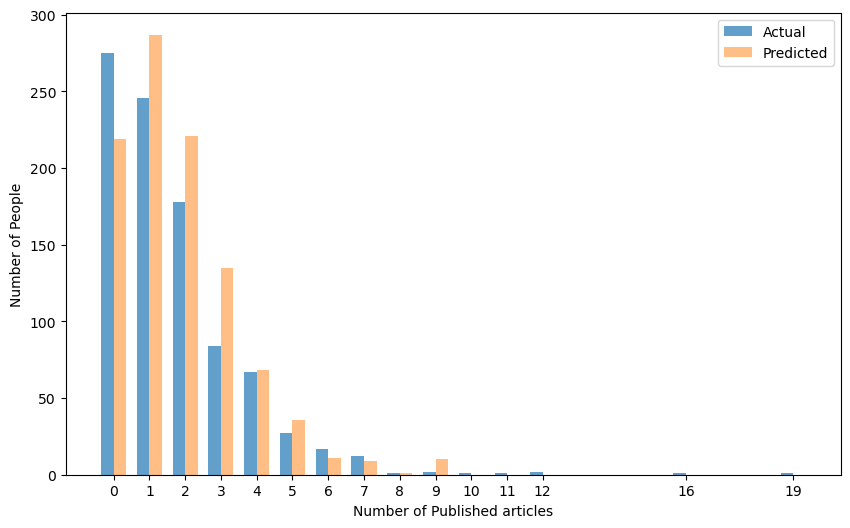

In [83]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 19]

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], num_people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Published articles")
plt.ylabel("Number of People")
plt.xticks(x)
plt.legend()
plt.show()


### Question 2: Estimate all relevant parameters for NBD regression using MLE. Report your code, the estimated parameters and the maximum value of the log-likelihood. What are the managerial takeaways | which customer characteristics seem to be important? Predict the number of people purchasing 0, ..., 20, 20+ packs based on the NBD regression. Explain how the predicted values are obtained using the case of 5 packs (show your calculations). Graph the original and predicted number of packs. 

In [84]:
# Setting up the parameters
params = np.array([0.5, 0.1, 0.2, 0.5, -0.3, -0.4, 0.3])
y = np.array(articls.articles)
x1 = np.array(articls.female)
x2 = np.array(articls.married)
x3 = np.array(articls.kids)
x4 = np.array(articls.prestige)
x5 = np.array(articls.menpubs)

In [85]:
# Defining the NBD-regression Log Likelihood fucntion

def NBDReg(params,x1,x2,x3,x4,x5, y):
    n,alpha,nbeta1, nbeta2, nbeta3, nbeta4, nbeta5 = params
    nll=0
    nll1=0
    nll2=0
    nll3=0
    nll4=0
    for i in range(len(x1)):
        beta=math.exp(nbeta1*x1[i]+nbeta2*x2[i]+nbeta3*x3[i]+nbeta4*x4[i]+nbeta5*x5[i])
        nll1=nll1+np.log(math.gamma(n+int(y[i])))
        nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(y[i])))
        nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
        nll4=nll4+int(y[i])*(np.log(beta)-np.log(alpha+beta))
    nll=nll1-nll2+nll3+nll4
    return nll*(-1)
    

In [86]:
# Minimizing the negative log-likelihood function value
NBD_result=minimize(NBDReg,  args=(x1,x2,x3,x4,x5,y),x0=params,bounds=[(0.00000001,None),(0.00000001,None),(None,None),(None,None),(None,None),(None,None), (None,None)],tol=1e-10,options={'ftol':1e-8})
n = NBD_result.x[0]
alpha=NBD_result.x[1]
beta1 = NBD_result.x[2]
beta2 = NBD_result.x[3]
beta3 = NBD_result.x[4]
beta4 = NBD_result.x[5]
beta5 = NBD_result.x[6]

In [87]:
nll=0
nll1=0
nll2=0
nll3=0
nll4=0

for i in range(len(x1)):
    beta=math.exp(beta1*x1[i]+beta2*x2[i]+beta3*x3[i]+beta4*x4[i]+beta5*x5[i])
    nll1=nll1+np.log(math.gamma(n+int(y[i])))
    nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(y[i])))
    nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
    nll4=nll4+int(y[i])*(np.log(beta)-np.log(alpha+beta))
nll=nll1-nll2+nll3+nll4

In [88]:
# Looking into the solution
NBD_result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1560.9583485324313
        x: [ 2.264e+00  1.752e+00 -2.165e-01  1.503e-01 -1.765e-01
             1.527e-02  2.908e-02]
      nit: 42
      jac: [ 3.797e-02 -4.970e-02  2.419e-02  2.083e-02  8.777e-03
             2.928e-01  1.112e+00]
     nfev: 416
     njev: 52
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

In [89]:
# Printing the optimal parameters
print("n: {}".format(n))
print("alpha:{}".format(alpha))
print("beta1: {}".format(beta1))
print("beta2: {}".format(beta2))
print("beta3: {}".format(beta3))
print("beta4: {}".format(beta4))
print("beta5: {}".format(beta5))


n: 2.26439089745491
alpha:1.7522257686707867
beta1: -0.2165367308069025
beta2: 0.15028362648143123
beta3: -0.1764500995916519
beta4: 0.015274510772891747
beta5: 0.029084447388650948


In [90]:
# Printing the maximum value of log-likelihood
ll_nbdreg = -NBD_result.fun
ll_nbdreg

-1560.9583485324313

In [91]:
# Predictions 0 to 20 
# Setting up the predict function
def predict_nbdr2(x1, x2, x3, x4, x5, y):
    predPr = []
    b = []
    for i in range(len(y)):  # This iterates over all elements in the input arrays
        b.append(math.exp(beta1 * x1[i] + beta2 * x2[i] + beta3 * x3[i] + beta4 * x4[i] + beta5 * x5[i] ))

    for j in range(len(y)):
        p_1 = (math.gamma(n + y[j])) / (math.gamma(n) * math.factorial(y[j]))
        p_2 = (alpha / (alpha + b[j])) ** n
        p_3 = (b[j] / (alpha + b[j])) ** y[j]
        pred = p_1 * p_2 * p_3
        predPr.append(pred)

    return predPr


In [92]:
# Setting up the parameters
y = np.array(articls.articles)
x1 = np.array(articls.female)
x2 = np.array(articls.married)
x3 = np.array(articls.kids)
x4 = np.array(articls.prestige)
x5 = np.array(articls.menpubs)

In [93]:
# Getting the predicted values/probabilities
ans2 = predict_nbdr2(x1, x2, x3, x4, x5, y)

In [94]:
ans2

[0.2498768547983746,
 0.36289664134598787,
 0.35521494119131364,
 0.33649777341703535,
 0.19973948499501118,
 0.45188137329009104,
 0.38372356482302405,
 0.37191958267981406,
 0.2893525920277358,
 0.37373662189827334,
 0.23455809521200008,
 0.3094991252074332,
 0.38928304249835477,
 0.32985231666347614,
 0.37127755881690366,
 0.4016742135170944,
 0.31097533370983393,
 0.2904768892753532,
 0.3484061758426724,
 0.32732929069906125,
 0.31812956913257445,
 0.4338423412364194,
 0.3061934687422658,
 0.3206830101044374,
 0.45238865861371264,
 0.346691891536884,
 0.34674273940680245,
 0.32276149795626685,
 0.41045479605598445,
 0.2816852987372763,
 0.41368698085270905,
 0.23554071377168984,
 0.30625956857402553,
 0.3502577557162195,
 0.36059471437859375,
 0.4154885924665091,
 0.4166437540864492,
 0.2670052840522641,
 0.3448101779956452,
 0.3199400976400536,
 0.2670052840522641,
 0.3930936407577965,
 0.3004232170145038,
 0.3907974748387241,
 0.30006316649588094,
 0.362133304472127,
 0.296995263

In [95]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_nr2 = articls.copy()
pred_nr2

,articles,female,married,kids,prestige,menpubs
0,0,0,1,0,2.52,7
1,0,1,0,0,2.05,6
2,0,1,0,0,3.75,6
3,0,0,1,1,1.18,3
4,0,1,0,0,3.75,26
...,...,...,...,...,...,...
910,11,0,1,2,2.86,7
911,12,0,1,1,4.29,35
912,12,0,1,1,1.86,5
913,16,0,1,0,1.74,21


In [96]:
# Creating a Pandas Series from the list `preds`.
preds_nr_series = pd.Series(ans2, name='preds_nbd')

# Inserting the Pandas Series into the DataFrame `pred_kch` as a new column.
pred_nr2.insert(loc=len(pred_nr2.columns), column='preds_nbd', value=preds_nr_series)


In [97]:
pred_nr2

,articles,female,married,kids,prestige,menpubs,preds_nbd
0,0,0,1,0,2.52,7,0.249877
1,0,1,0,0,2.05,6,0.362897
2,0,1,0,0,3.75,6,0.355215
3,0,0,1,1,1.18,3,0.336498
4,0,1,0,0,3.75,26,0.199739
...,...,...,...,...,...,...,...
910,11,0,1,2,2.86,7,0.000141
911,12,0,1,1,4.29,35,0.008369
912,12,0,1,1,1.86,5,0.000114
913,16,0,1,0,1.74,21,0.000426


In [98]:
# Getting the unique visit counts
unique_acls = np.unique(pred_nr2['articles'])

# Initializing a dictionary to store the results
results_by_acls = {}

# Looping through each unique visit count
for visit_count in unique_acls:
    indices = np.where(pred_nr2['articles'] == visit_count)[0]
    pred_sum = pred_nr2.loc[indices, 'preds_nbd'].sum()
    results_by_acls[visit_count] = {'pred_sum': pred_sum, 'num_indices': len(indices)}

# Printing the results.
for visit_count, result in results_by_acls.items():
    print(f"Articles published: {visit_count}, Predicted Sum: {result['pred_sum']}, Number of Authors: {result['num_indices']}")


Articles published: 0, Predicted Sum: 91.73611323030221, Number of Authors: 275
Articles published: 1, Predicted Sum: 67.54436999797352, Number of Authors: 246
Articles published: 2, Predicted Sum: 32.108709213091316, Number of Authors: 178
Articles published: 3, Predicted Sum: 9.46346282867167, Number of Authors: 84
Articles published: 4, Predicted Sum: 4.529246320806235, Number of Authors: 67
Articles published: 5, Predicted Sum: 1.1886325867083587, Number of Authors: 27
Articles published: 6, Predicted Sum: 0.4249320309149419, Number of Authors: 17
Articles published: 7, Predicted Sum: 0.2468437511966154, Number of Authors: 12
Articles published: 8, Predicted Sum: 0.00999876246937751, Number of Authors: 1
Articles published: 9, Predicted Sum: 0.05126262167599627, Number of Authors: 2
Articles published: 10, Predicted Sum: 0.0030893137958490436, Number of Authors: 1
Articles published: 11, Predicted Sum: 0.00014144141620563548, Number of Authors: 1
Articles published: 12, Predicted S

In [99]:
# Setting up the values to plot the graph, from the above information.
num_people=[275, 246, 178, 84, 67, 27, 17, 12, 1, 2, 1, 1, 2, 1, 1]

In [100]:
probs = np.zeros(len(results_by_acls))

In [101]:
# Initializing an array to store the calculated values
calculated_values_nbdr = np.zeros(len(results_by_acls))

# Looping through each unique visit count
for i, (visit_count, result) in enumerate(results_by_acls.items()):
    calculated_values_nbdr[i] = (result['pred_sum'] / result['num_indices']) * 915

In [102]:
# Prediction of people corresponding to number of articles published ( 0 to 10 and 11, 12, 16 and 19 published articles cases)
calculated_values_nbdr

array([3.05231068e+02, 2.51232108e+02, 1.65053196e+02, 1.03084149e+02,
       6.18546326e+01, 4.02814377e+01, 2.28713417e+01, 1.88218360e+01,
       9.14886766e+00, 2.34526494e+01, 2.82672212e+00, 1.29418896e-01,
       3.88094283e+00, 3.89827275e-01, 2.57504291e+00])

In [103]:
# Converting the predicted values into integers for the purpose of plotting the graph.
predicted_people = calculated_values_nbdr
predicted_people = [int(x) for x in predicted_people]
predicted_people

[305, 251, 165, 103, 61, 40, 22, 18, 9, 23, 2, 0, 3, 0, 2]

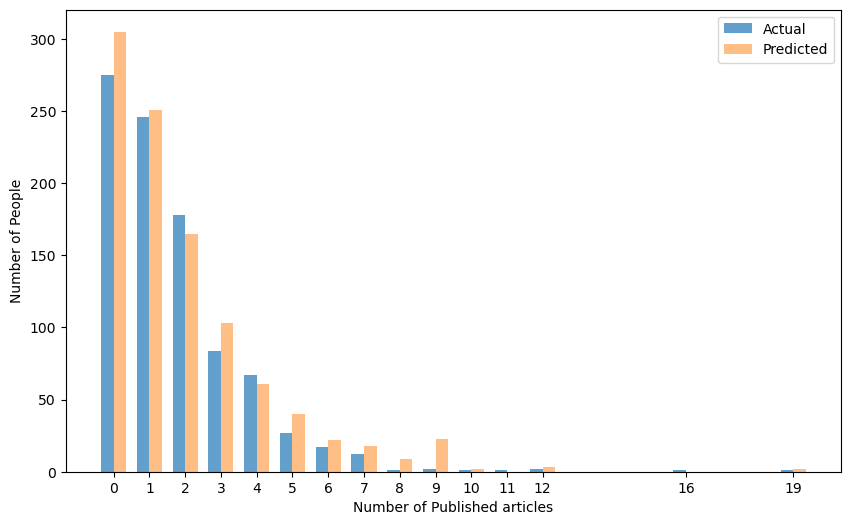

In [104]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 19]

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], num_people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Published articles")
plt.ylabel("Number of People")
plt.xticks(x)
plt.legend()
plt.show()

### Question 3: In this question, you will apply the ideas learned in this course to build a model that you have not seen before – the Zero-Inflated NBD regression. Explain the logic used in developing the model in detail. Report your code, the estimated parameters and the maximum value of the log-likelihood. What are the managerial takeaways – which customer characteristics seem to be important? Predict the number of people purchasing 0, …, 20, 20+ packs based on the Poisson regression. Explain how the predicted values are obtained using the case of 5 packs (show your calculations). Graph the original and predicted number of packs.

In [105]:
# Setting up the parameters
params = np.array([0.6, 0.5, 0.1, 0.2, 0.5, -0.3, -0.4, 0.3])
v = np.array(articls.articles)
x1 = np.array(articls.female)
x2 = np.array(articls.married)
x3 = np.array(articls.kids)
x4 = np.array(articls.prestige)
x5 = np.array(articls.menpubs)

In [106]:
# Defining the log-likelihood function
def zi_nbdr(params, v, x1, x2, x3, x4, x5):
    pi, n, alpha, nbeta1, nbeta2, nbeta3, nbeta4, nbeta5 = params
  
    
    pr_0 = 0
    nll=0
    nll1=0
    nll2=0
    nll3=0
    nll4=0
    
    for i in range(len(articls)):
        if v[i]==0:
            beta=math.exp(nbeta1*x1[i]+nbeta2*x2[i]+nbeta3*x3[i]+nbeta4*x4[i]+nbeta5*x5[i])
            pr_0 += np.log(pi) + np.log(1-pi) + ( n * np.log((alpha/(alpha+beta))))
            
        else:
            beta=math.exp(nbeta1*x1[i]+nbeta2*x2[i]+nbeta3*x3[i]+nbeta4*x4[i]+nbeta5*x5[i])
            nll1=nll1+np.log(math.gamma(n+int(v[i])))
            nll2=nll2+np.log(math.gamma(n))+np.log(factorial(int(v[i])))
            nll3=nll3+n*(np.log(alpha)-np.log(alpha+beta))
            nll4=nll4+int(v[i])*(np.log(beta)-np.log(alpha+beta))
            nll=np.log(1-pi)+nll1-nll2+nll3+nll4
   
    # final_llr = np.sum(ll_0) + nll
    return  -(pr_0+nll)

In [107]:
# Minimizing the negative log-likelihood function
zi_nbdr_soln=minimize(zi_nbdr,  args=(v,x1,x2,x3,x4,x5),x0=params,bounds=[(0.000001,0.99999999),(0.00000001,None),(0.00000001,None),(None,None),(None,None),(None,None),(None,None), (None,None)],tol=1e-10,options={'ftol':1e-8})


In [108]:
# Looking into the solution
zi_nbdr_soln

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1942.8815628741352
        x: [ 4.991e-01  2.265e+00  1.753e+00 -2.164e-01  1.511e-01
            -1.766e-01  1.523e-02  2.909e-02]
      nit: 49
      jac: [ 1.251e-01 -9.641e-03  1.507e-02 -2.321e-02  7.042e-02
            -2.867e-02 -1.167e-01  3.419e-01]
     nfev: 531
     njev: 59
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>

In [109]:
# Printing out the optimal parameters.
optimal_pi, optimal_n, optimal_a, optimal_b1, optimal_b2, optimal_b3, optimal_b4, optimal_b5  = zi_nbdr_soln.x
print(f"Optimal pi: {optimal_pi}")
print(f"Optimal n: {optimal_n}")
print(f"Optimal a: {optimal_a}")
print(f"Optimal b1: {optimal_b1}")
print(f"Optimal b2: {optimal_b2}")
print(f"Optimal b3: {optimal_b3}")
print(f"Optimal b4: {optimal_b4}")
print(f"Optimal b5: {optimal_b5}")


Optimal pi: 0.4991492845469428
Optimal n: 2.264568125358856
Optimal a: 1.7533572731781364
Optimal b1: -0.21641933168057265
Optimal b2: 0.1510893053456499
Optimal b3: -0.17663029235647884
Optimal b4: 0.015233411468552345
Optimal b5: 0.02909010409971426


In [110]:
# Printing the maximum value of log-likelihood
ll_zi_nbdr = -zi_nbdr_soln.fun
ll_zi_nbdr

-1942.8815628741352

In [111]:
# Predictions 0 to 20
# Setting up the predict function
def predict_zinbdr2(v, x1, x2, x3, x4, x5):
    pred_zinbdr = []
    for i in range(len(articls)):
        if v[i]==0:
            beta=math.exp(optimal_b1*x1[i]+optimal_b2*x2[i]+optimal_b3*x3[i]+optimal_b4*x4[i]+optimal_b5*x5[i])
            res_znr = optimal_pi + (1-optimal_pi) * ((optimal_a/(optimal_a+beta))**optimal_n)
            pred_zinbdr.append(res_znr)
            
        else:
            beta=math.exp(optimal_b1*x1[i]+optimal_b2*x2[i]+optimal_b3*x3[i]+optimal_b4*x4[i]+optimal_b5*x5[i])
            p_1 = (math.gamma(optimal_n + v[i])) / (math.gamma(optimal_n) * math.factorial(v[i]))
            p_2 = (optimal_a / (optimal_a + beta)) ** optimal_n
            p_3 = (beta / (optimal_a + beta)) ** v[i]
            pred = (1-optimal_pi) * p_1 * p_2 * p_3
            pred_zinbdr.append(pred)
    return pred_zinbdr
            


In [112]:
# Setting up the parameters
v = np.array(articls.articles)
x1 = np.array(articls.female)
x2 = np.array(articls.married)
x3 = np.array(articls.kids)
x4 = np.array(articls.prestige)
x5 = np.array(articls.menpubs)

In [113]:
ans3 = predict_zinbdr2(v, x1, x2, x3, x4, x5)

In [114]:
ans3

[0.6242742233216774,
 0.6809778258178243,
 0.6771403582537898,
 0.6676775857061195,
 0.5992380563541679,
 0.7254935437543706,
 0.6914195135331074,
 0.685455729731288,
 0.6441685991951921,
 0.6862873296085404,
 0.616701106744413,
 0.6542168286461181,
 0.6941131965724314,
 0.6643184732260831,
 0.6850590594996546,
 0.7004118425876116,
 0.654853875564053,
 0.6446627665491378,
 0.6737265489653387,
 0.6631725304320926,
 0.6584391185916071,
 0.7164989516911047,
 0.6525160585799987,
 0.6597658138279165,
 0.725788427228358,
 0.6727416839188106,
 0.6728016631488678,
 0.660816120663496,
 0.7048106985571199,
 0.6402063872464602,
 0.7064252585328994,
 0.6171030053009166,
 0.6525984199684356,
 0.6746695328341522,
 0.6797512278953504,
 0.7073252061290392,
 0.7079022352235727,
 0.6329684227382419,
 0.6718419560090314,
 0.6593554529768713,
 0.6329684227382419,
 0.6960166154594587,
 0.6497115903835621,
 0.6948696661961504,
 0.6495199205354785,
 0.6805197678605175,
 0.6478766292729501,
 0.565293446409292

In [115]:
# Setting up the dataset for easy calculation of predictions and also for plotting the graph.
pred_zinr = articls.copy()
pred_zinr

,articles,female,married,kids,prestige,menpubs
0,0,0,1,0,2.52,7
1,0,1,0,0,2.05,6
2,0,1,0,0,3.75,6
3,0,0,1,1,1.18,3
4,0,1,0,0,3.75,26
...,...,...,...,...,...,...
910,11,0,1,2,2.86,7
911,12,0,1,1,4.29,35
912,12,0,1,1,1.86,5
913,16,0,1,0,1.74,21


In [116]:
# Creating a Pandas Series from the list `preds`.
preds_nr_series = pd.Series(ans3, name='preds_zinbd')

# Inserting the Pandas Series into the DataFrame `pred_kch` as a new column.
pred_zinr.insert(loc=len(pred_zinr.columns), column='preds_zinbd', value=preds_nr_series)


In [117]:
pred_zinr

,articles,female,married,kids,prestige,menpubs,preds_zinbd
0,0,0,1,0,2.52,7,0.624274
1,0,1,0,0,2.05,6,0.680978
2,0,1,0,0,3.75,6,0.677140
3,0,0,1,1,1.18,3,0.667678
4,0,1,0,0,3.75,26,0.599238
...,...,...,...,...,...,...,...
910,11,0,1,2,2.86,7,0.000071
911,12,0,1,1,4.29,35,0.004192
912,12,0,1,1,1.86,5,0.000057
913,16,0,1,0,1.74,21,0.000214


In [118]:
# Getting the unique visit counts
unique_acls = np.unique(pred_zinr['articles'])

# Initializing a dictionary to store the results
results_by_acls = {}

# Looping through each unique visit count
for visit_count in unique_acls:
    indices = np.where(pred_zinr['articles'] == visit_count)[0]
    pred_sum = pred_zinr.loc[indices, 'preds_zinbd'].sum()
    results_by_acls[visit_count] = {'pred_sum': pred_sum, 'num_indices': len(indices)}

# Printing the results.
for visit_count, result in results_by_acls.items():
    print(f"Articles published: {visit_count}, Predicted Sum: {result['pred_sum']}, Number of Authors: {result['num_indices']}")


Articles published: 0, Predicted Sum: 183.21869008217982, Number of Authors: 275
Articles published: 1, Predicted Sum: 33.83116915449227, Number of Authors: 246
Articles published: 2, Predicted Sum: 16.081230564161736, Number of Authors: 178
Articles published: 3, Predicted Sum: 4.739450363778456, Number of Authors: 84
Articles published: 4, Predicted Sum: 2.2682037125485177, Number of Authors: 67
Articles published: 5, Predicted Sum: 0.5953118383981361, Number of Authors: 27
Articles published: 6, Predicted Sum: 0.21275127019657283, Number of Authors: 17
Articles published: 7, Predicted Sum: 0.12353290414943982, Number of Authors: 12
Articles published: 8, Predicted Sum: 0.005010595270127947, Number of Authors: 1
Articles published: 9, Predicted Sum: 0.025682164182711784, Number of Authors: 2
Articles published: 10, Predicted Sum: 0.0015490601852192868, Number of Authors: 1
Articles published: 11, Predicted Sum: 7.074082287585446e-05, Number of Authors: 1
Articles published: 12, Predi

In [119]:
# Setting up the values to plot the graph, from the above information.
num_people=[275, 246, 178, 84, 67, 27, 17, 12, 1, 2, 1, 1, 2, 1, 1]

In [120]:
# Initializing an array to store the calculated values
calculated_values_zinbdr = np.zeros(len(results_by_acls))

# Looping through each unique visit count
for i, (visit_count, result) in enumerate(results_by_acls.items()):
    calculated_values_zinbdr[i] = (result['pred_sum'] / result['num_indices']) * 915

In [121]:
# Prediction of people corresponding to number of articles published ( 0 to 10 and 11, 12, 16 and 19 published articles cases)
calculated_values_zinbdr

array([6.09618551e+02, 1.25835446e+02, 8.26647526e+01, 5.16261557e+01,
       3.09762149e+01, 2.01744567e+01, 1.14510242e+01, 9.41938394e+00,
       4.58469467e+00, 1.17495901e+01, 1.41739007e+00, 6.47278529e-02,
       1.94414214e+00, 1.95533175e-01, 1.29171974e+00])

In [122]:
# Converting the predicted values into integers for the purpose of plotting the graph.
predicted_people = calculated_values_zinbdr
predicted_people = [int(x) for x in predicted_people]
predicted_people

[609, 125, 82, 51, 30, 20, 11, 9, 4, 11, 1, 0, 1, 0, 1]

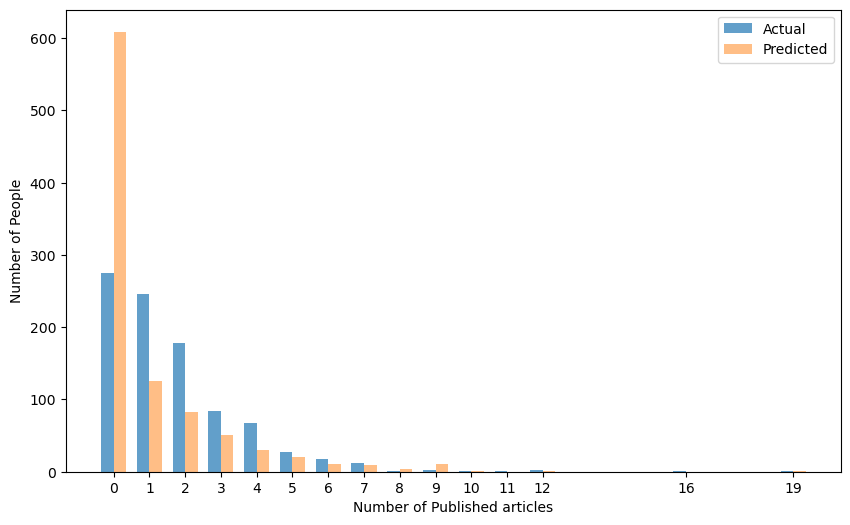

In [123]:
# Plotting the actual vs the predicted data.
bar_width = 0.35
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 19]

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width/2 for i in x], num_people, bar_width, alpha=0.7, label="Actual", color="tab:blue")
plt.bar([i + bar_width/2 for i in x], predicted_people, bar_width, alpha=0.5, label="Predicted", color="tab:orange")
plt.xlabel("Number of Published articles")
plt.ylabel("Number of People")
plt.xticks(x)
plt.legend()
plt.show()

### Question 4: Evaluate the models developed; explain which of them is best, and why. Are there any significant differences among the results from these models? If so, what exactly are these differences? Discuss what you believe could be causing the differences. 

In [124]:
# Poisson Regression
k = 6
n = 915
aic_pr = (2*k) - 2*(-1651.0563161691005)
bic_pr = k*np.log(n) - 2*(-1651.0563161691005)
print("Poisson Regression Model AIC: ", aic_pr)
print("Poisson Regression Model BIC: ", bic_pr)

Poisson Regression Model AIC:  3314.112632338201
Poisson Regression Model BIC:  3343.026176729854


In [125]:
# NBD Regression
k = 7
n = 915
aic_nbdr = (2*k) - 2*(-1560.9583485324313)
bic_nbdr = k*np.log(n) - 2*(-1560.9583485324313)
print("NBD Regression Model AIC: ", aic_nbdr)
print("NBD Regression Model BIC: ", bic_nbdr)


NBD Regression Model AIC:  3135.9166970648625
NBD Regression Model BIC:  3169.649165521791


In [126]:
# Zero Inflated NBD Regression
k = 8
n = 915
aic_zinbdr = (2*k) - 2*(-1942.8815628741352)
bic_zinbdr = k*np.log(n) - 2*(-1942.8815628741352)
print("Zero NBD Regression Model AIC: ", aic_zinbdr)
print("Zero NBD Regression Model BIC: ", bic_zinbdr) 

Zero NBD Regression Model AIC:  3901.7631257482703
Zero NBD Regression Model BIC:  3940.3145182704743


In [127]:
# Likelihood Ratio test between NBD Regression and Zero Inflated NBD Regression:
# LL_NBDRegressionModel = -1560.9583485324313
# LL_ZeroInflatedNBDRegression = -1942.8815628741352
lrt_nbd_zinbd = 2 * (1942.8815628741352-(1560.9583485324313))
lrt_nbd_zinbd

763.8464286834078